In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../simulation_example")
from generate_data import simulate_data, plot_res
from fittingmethods import fit_nn, fit_ngboost, fit_indep_ngboost,  fit_skGB
import numpy as np

# randomseed
SEED = 230521
N = 50
np.random.seed(SEED)


X, Y, true_dists  = simulate_data(5000, sort=False)
X = X.reshape(-1,1)
X_valid, Y_valid, _  = simulate_data(300)
X_test, Y_test , true_test  = simulate_data(1000, sort=True)
X_valid = X_valid.reshape(-1,1)

data = (X,Y)

In [2]:
model, t = fit_nn(X, Y, X_valid, Y_valid, hidden_layers=[100], learning_rate=0.01,verbose=0)
NN_test_distns = model.scipy_distribution(X_test)

In [3]:
X = X.reshape(-1,1)
model, t = fit_ngboost(X, Y, X_valid, Y_valid)
NGBoost_test_distns = model.pred_dist(X_test).scipy_distribution()

/home/omalley3/anaconda3/envs/experiments/lib/python3.7/site-packages/ngboost/distns/distn.py:39: UserWarning: Using Dist=MVNLogScore is unnecessary. NGBoost automatically selects the correct implementation when LogScore or CRPScore is used
  f"Using Dist={Score.__name__} is unnecessary. "


[iter 0] loss=3.5902 val_loss=3.4695 scale=1.0000 norm=2.9665
[iter 100] loss=2.1082 val_loss=2.1046 scale=2.0000 norm=2.2473
[iter 200] loss=1.2977 val_loss=1.3477 scale=2.0000 norm=2.3095
[iter 300] loss=0.8594 val_loss=0.9567 scale=2.0000 norm=3.1096
[iter 400] loss=0.6739 val_loss=0.8074 scale=1.0000 norm=2.1468
[iter 500] loss=0.6272 val_loss=0.7830 scale=1.0000 norm=2.4965
[iter 600] loss=0.6051 val_loss=0.7769 scale=2.0000 norm=5.3497
== Early stopping achieved.
== Best iteration / VAL617 (val_loss=0.7764)


../simulation_example/generate_data.py:85: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


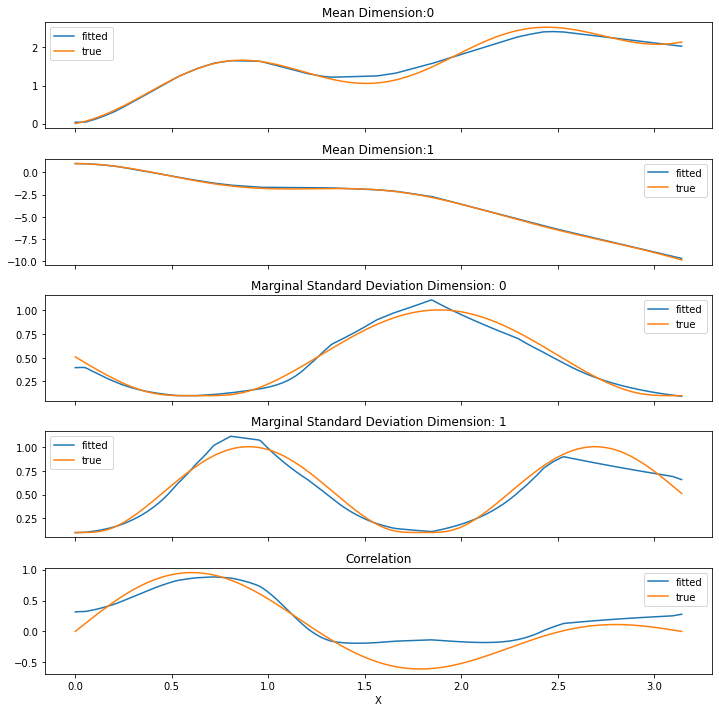

In [4]:
plot_res(X_test, NN_test_distns, true_test, figsize=(10,10))

../simulation_example/generate_data.py:85: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


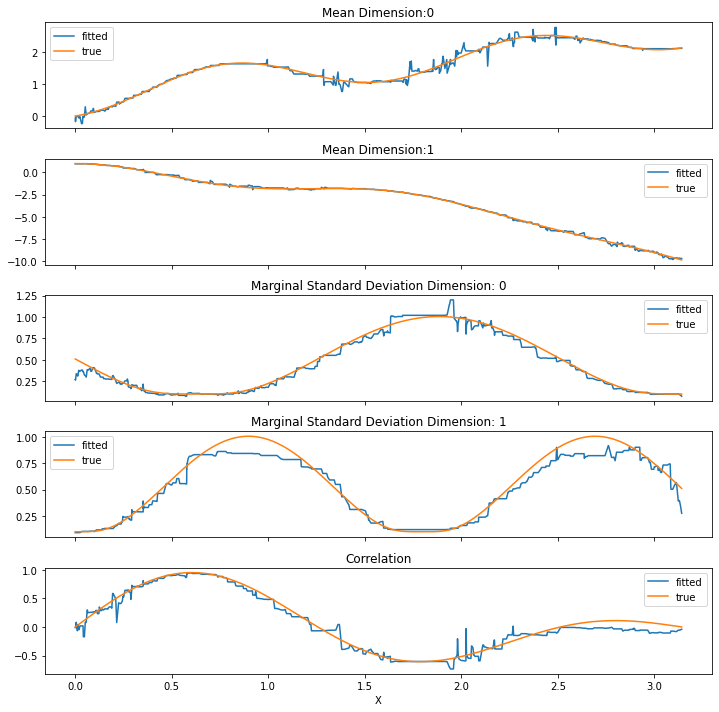

In [5]:
plot_res(X_test, NGBoost_test_distns, true_test, figsize=(10,10))

## Simulated_Data.pdf generation

## Figure 2 in the paper

(1000, 5)
(5,)
(1000, 5)
(5,)
(1000, 5)
(5,)


FileNotFoundError: [Errno 2] No such file or directory: '../Images/Simulated_Data.pdf'

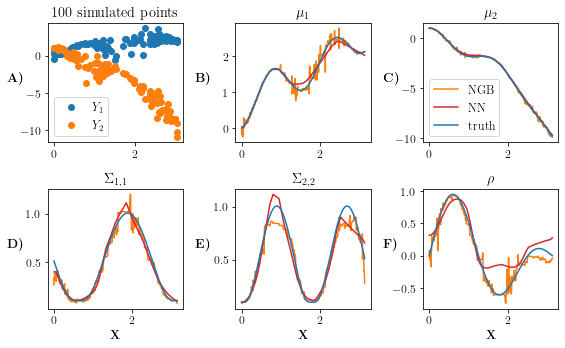

In [6]:
import matplotlib.pyplot as plt
from generate_data import cov_to_sigma
from probdrift import mpl_config
import string

plt.rcParams.update(mpl_config)

fig, ax = plt.subplots(2,3,figsize=(8,5))

ax[0,0].plot(X[:100], Y[:100,0], 'o', color='tab:blue', label= "$Y_1$")
ax[0,0].plot(X[:100], Y[:100,1], 'o', color='tab:orange', label = "$Y_2$")

def plot_distn(X, dists, axs, plot_kwargs):

    order = np.argsort(X.flatten())
    x_plot = X.flatten()[order]


    true_mean = np.array([dists[i].mean for i in order])
    true_cov_mat = np.array([dists[i].cov for i in order])
    true_sigma, true_corrs = cov_to_sigma(true_cov_mat)
    # Plot the parameters in the sigma, correlation representation
    pars = np.hstack([true_mean, true_sigma, true_corrs.reshape(-1,1)])
    print(pars.shape)
    titles = ['$\mu_1$', "$\mu_2$", "$\Sigma_{1,1}$", "$\Sigma_{2,2}$", "$\\rho$"]
    colors = ["blue", "red"]
    print(axs.shape)
    for i in range(0,5):
        axs[i].set_title(titles[i])
        axs[i].plot(x_plot, pars[:, i], **plot_kwargs)

    


plot_distn(X_test, NGBoost_test_distns, ax.flatten()[1:], {'label':'NGB', 'color':'tab:orange'})
plot_distn(X_test, NN_test_distns, ax.flatten()[1:], {'label':'NN', 'color':'tab:red'})
plot_distn(X_test, true_test, ax.flatten()[1:], {'label':'truth', 'color':'tab:blue'})

for n, axs in enumerate(ax.flatten()):
    axs.text(-0.3, 0.5, "\\textbf{"+ string.ascii_uppercase[n]+")}", transform=axs.transAxes, 
        size=13, weight='bold')


ax[0,0].legend()
ax[0,2].legend()
ax[0,0].set_title("100 simulated points")
for i in range(3):
    ax[1,i].set_xlabel("$\mathbf{X}$")
fig.tight_layout()
fig.savefig("../Images/Simulated_Data.pdf", bbox_inches='tight')


In [ ]:
from ngboost.distns.multivariate_normal import MultivariateNormal, MVNLogScore
from jax import jit, vmap, jacobian, jacfwd, jacrev
from jax import numpy as jnp
import jax
from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors

def fill_UD(cov_pars):
    k = 2
    D = jnp.diag(jnp.exp(cov_pars[:k]))
    U = jnp.identity(k)
    U = jax.ops.index_update(U, jax.ops.index[1, 0], cov_pars[k])
    return U, D



def UD_to_L(params):
    out = params
    mean = params[:2]
    cov = params[2:]
    U,D = fill_UD(cov)
    L = U@D
    b = tfb.TransformDiagonal(tfb.Exp())
    L = b.inverse(L)
    return jnp.concatenate([mean, L[jnp.tril_indices(2)]])

def fill_L(cov_params):
    L = jnp.diag(jnp.exp(jnp.array([cov_params[0], cov_params[2]])))
    L = jax.ops.index_update(L, jax.ops.index[1, 0], cov_params[1])
    return L


def L_to_UD(params):
    """
    Only implemented for 2d data

    Parameters
    ----------
    params parametization in the sigma_inv = LL^T decomposition

    Returns
    -------
    parameterization in the sigma_inv=UD(DU).tranpose() decomposition

    """
    mean = params[:2]
    cov = params[2:]
    #L = fill_L(cov)
    #D = jnp.diag(jnp.diag(L))
    #U = np.linalg.solve(jnp.transpose(D), jnp.transpose(L))

    #b = tfb.TransformDiagonal(tfb.Exp())
    #D = b.inverse(D)
    cov_trans  = jnp.array([cov[0], cov[2], cov[1]/jnp.exp(cov[0])])
    out = jnp.concatenate([mean, cov_trans])
    return out



def MVN_transformed(transform, inverse, base_class = MultivariateNormal(2)):
    jacobian_jax = jit(vmap(jacobian(transform),1))
    transform_jax = jit(vmap(transform,1))
    class MVN_T_LogScore(MVNLogScore):
        def score(self, Y):
            return super().score(Y)
        def d_score(self, Y):
            orig_grad = super().d_score(Y)
            trans_grad = np.squeeze(np.expand_dims(orig_grad,1)@self.jacobian)
            return trans_grad
        
        def metric(self):
            metric = super().metric()
            trans_metric = np.transpose(self.jacobian, (0,2,1)) @ metric @ self.jacobian
            return trans_metric
        
    class MVN_transform(base_class):
        """
        Implementation of the Multivariate normal distribution for regression.
        Using the parameterization Sigma^{-1} = LL^T and modelling L
        diag(L) is exponentiated to ensure parameters are unconstrained.
        Scipy's multivariate normal benchmarks were relatively
        slow for pdf calculations so the implementation is from scratch.
        As Scipy has considerably more features call self.scipy_distribution()
        to return a list of distributions.
        """
        k = 2
        n_params = int(k * (k + 3) / 2)
        scores = [MVN_T_LogScore]
        multi_output = True

        # pylint: disable=super-init-not-called
        def __init__(self, params):
            self.transform = transform_jax
            self.orig_params = params
            self.jacobian = jacobian_jax(params)
            super().__init__(self.transform(params).T)

        def logpdf(self, Y):
            return super().logpdf(Y)
        
        def fit(Y):
            fit = base_class.fit(Y)
            print(inverse(fit))
            return inverse(fit)
                
    
    return MVN_transform
t_class = MVN_transformed(UD_to_L, L_to_UD)

UD_to_L(L_to_UD(np.array([0,1,0.3,0.5,.9])))